# 7.3 MLP on bank marketing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from Dataset import Dataset
from utils import get_splits

# Model training

In [2]:
df = pd.read_csv('data/bank-full.csv', header=0,sep=";")

In [3]:
df = df.drop(['month','day','duration'], axis=1)

In [4]:
df = pd.get_dummies(df,drop_first=True)

In [5]:
X = df.drop(['y_yes'], axis=1)
y = df['y_yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [6]:
mlp = MLPClassifier(hidden_layer_sizes=(100,75), random_state=0)

In [7]:
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 75), random_state=0)

In [8]:
probs = mlp.predict_proba(X_test)

In [9]:
mlp.score(X_test, y_test)

0.8887496313771749

In [10]:
df_test = pd.DataFrame(X_test)
df_test['actual'] = y_test

In [11]:
df_test[['prob_0','prob_1']] = probs

In [12]:
df_test['pred'] = df_test['prob_1'].apply(lambda x: 0 if x<0.5 else 1)

# Calibration analysis

In [13]:
df = pd.read_csv('data/bank_out.csv', index_col=0)
var='Age'
df[var] = df['age']
df = Dataset(df, cal_size=1000)

## Uncalibrated

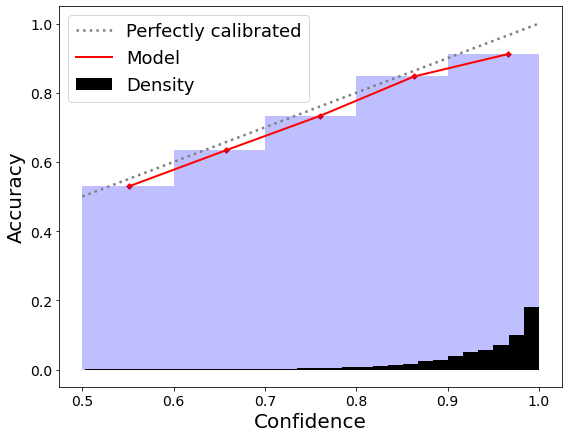

In [14]:
df.reliability_diagram(hist_weight=0.00005, filename="figs/bank_uncal_reliability.png")

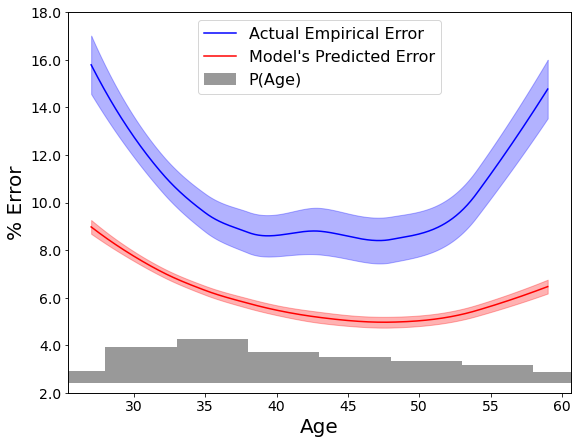

In [15]:
ylim = df.gen_plot_lowess(var=var,s=0.9, hist=True, d2 = 2, 
                          loc='upper center',filename="figs/bank_uncal_errdiff.png")

## Logistic (Platt scaling)-calibrated

In [16]:
cont = ['age','balance']

In [17]:
for col in cont:
    print(col)
    print(df.compute_VECE(col, label="_log"))

age
0.028295085861533772
balance
0.04170544679462558


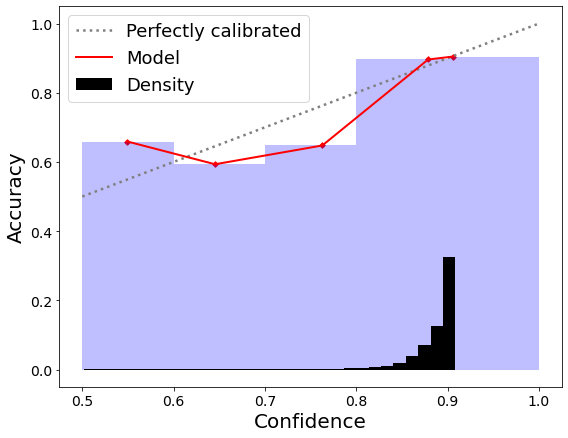

In [18]:
df.reliability_diagram(label="_log", hist_weight=0.00005, filename="figs/bank_kumar_reliability.png")

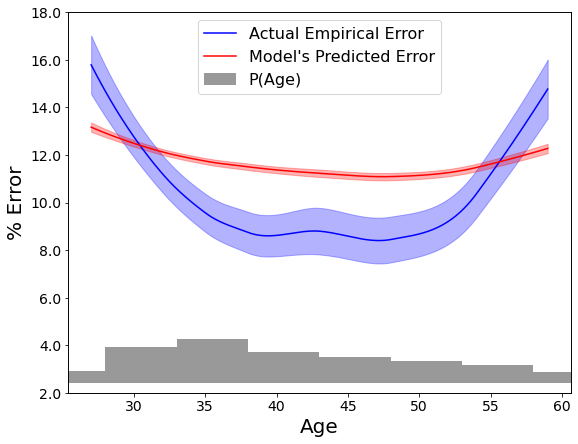

In [19]:
df.gen_plot_lowess(var=var, label='_log', use_lim=True, loc='upper center',
                   ylim=ylim,s=0.9,hist=True,d2=2, filename="figs/bank_kumar_errdiff.png")

## Beta-z calibrated

In [20]:
df.augmented_z_calibrate(var=var, label="_betaz2", degree=2)

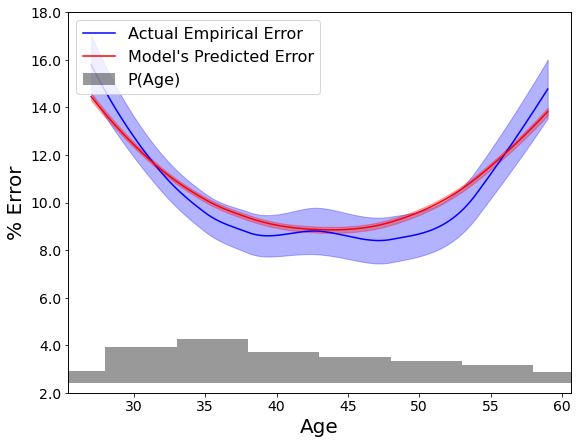

In [21]:
df.gen_plot_lowess(var=var, label="_betaz2", use_lim=True, ylim=ylim, d2=2,
                   filename="figs/bank_betaz_errdiff.png", s=0.9, hist=True)

## Variable-wise calibrated

In [22]:
splits = get_splits(df.df_cal[[var]], df.df[[var]], df.df_cal['actual'], df.df['actual'],
                    min_samples_leaf=int(len(df.df_cal)/20))

In [23]:
df.split_calibrate(var, splits, how='beta')

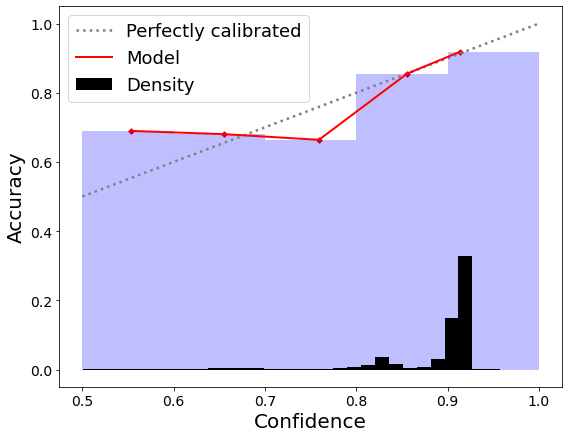

In [24]:
df.reliability_diagram(label="_split", hist_weight=0.00005, filename="figs/bank_split_reliability.png")

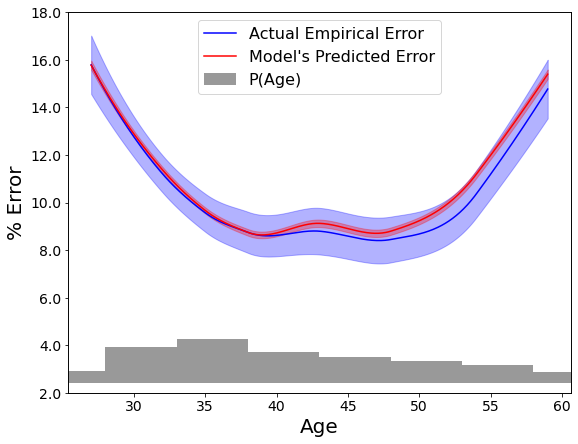

In [25]:
df.gen_plot_lowess(var=var, label='_split', use_lim=True, loc='upper center',
                   ylim=ylim,s=0.9, d2=2, hist=True, filename="figs/bank_split_errdiff.png")

## Overall results

In [26]:
print('uncalibrated accuracy=',df.compute_accuracy())
print("Logistic calibrated accuracy=",df.compute_accuracy(label="_log"))
print("Variable-wise calibrated accuracy=",df.compute_accuracy(label="_split"))

uncalibrated accuracy= 0.8888888888888888
Logistic calibrated accuracy= 0.887217446673034
Variable-wise calibrated accuracy= 0.8866602992677491


In [27]:
bins=10

In [28]:
print("uncalibrated ECE=",df.compute_ECE(num_bins=bins))
print("Kumar calibrated ECE=",df.compute_ECE(label="_kumar", num_bins=bins))
print("Logistic calibrated ECE=", df.compute_ECE(label="_log", num_bins=bins))
print("Beta calibrated ECE=", df.compute_ECE(label="_beta", num_bins=bins))
print("Variable-wise calibrated ECE=",df.compute_ECE(label="_split", num_bins=bins))
print("Beta-z2 calibrated ECE=",df.compute_ECE(label="_betaz2", num_bins=bins))

uncalibrated ECE= 0.04693462497601752
Kumar calibrated ECE= 0.04368286591199143
Logistic calibrated ECE= 0.023803035745549178
Beta calibrated ECE= 0.024817942321657908
Variable-wise calibrated ECE= 0.020990727411351853
Beta-z2 calibrated ECE= 0.02092216184850879


In [29]:
print("uncalibrated VECE =",df.compute_VECE(var=var, num_bins=bins))
print("Kumar calibrated VECE =",df.compute_VECE(label="_kumar",var=var, num_bins=bins))
print("Logistic calibrated VECE =",df.compute_VECE(label="_log",var=var, num_bins=bins))
print("Beta calibrated VECE =",df.compute_VECE(label="_beta",var=var, num_bins=bins))
print("Variable-wise calibrated VECE =",df.compute_VECE(label="_split",var=var, num_bins=bins))
print("Beta-z2 calibrated VECE=",df.compute_VECE(label="_betaz2",var=var, num_bins=bins))

uncalibrated VECE = 0.0469346249760175
Kumar calibrated VECE = 0.03387231768926998
Logistic calibrated VECE = 0.028295085861533762
Beta calibrated VECE = 0.02771482117480024
Variable-wise calibrated VECE = 0.005239158060853571
Beta-z2 calibrated VECE= 0.011253661180957636


In [30]:
for col in ['age','balance']:
    print(col)
    print("uncalibrated", df.compute_VECE(col))
    print("log", df.compute_VECE(col, label="_log"))
    print("variable-wise", df.compute_VECE(col, label="_split"))
    print()

age
uncalibrated 0.0469346249760175
log 0.028295085861533762
variable-wise 0.005239158060853571

balance
uncalibrated 0.05351020704242146
log 0.041705446794625574
variable-wise 0.032180636115586844

